# Policy analysis
The point of this notebook is to analyze the privacy policies fetched with the spider.  
This presumes all the policies that are marked as successfully gathered in the report file are good, and only looks at said policies

In [16]:
import os
import json
import justext
import math
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import langid

In [32]:
def site_name_from_file_name(file_name):
    return file_name[len("policy_"):len(file_name) - 4]

## 1 Overview

In [2]:
DATADIR = "data/"
POLICY_FILE_PREFIX = "policy_"
REPORT_FILE_NAME = "crawl_report.json"

In [3]:
report_json = pd.read_json(DATADIR + REPORT_FILE_NAME)
report_json

,url,policy_domain,policy_url,policy_file,uses_iubenda,success
0,https://www.corriere.it/,www.corriere.it,https://www.corriere.it/privacy.shtml,policy_www.corriere.it.txt,False,True
1,https://www.gazzetta.it/,www.gazzetta.it,https://www.gazzetta.it/privacy.shtml,policy_www.gazzetta.it.txt,False,True
2,https://www.repubblica.it/,None,None,policy_www.repubblica.it.txt,True,False
3,https://www.youtube.com/,www.youtube.com,https://www.youtube.com/t/privacy,policy_www.youtube.com.txt,False,True
4,https://twitter.com,twitter.com,https://twitter.com/privacy,policy_twitter.com.txt,False,True
...,...,...,...,...,...,...
76,https://www.dailyfx.com/,www.dailyfx.com,https://www.dailyfx.com/cookies,policy_www.dailyfx.com.txt,False,True
77,https://www.paypal.com/it/home,www.paypal.com,https://www.paypal.com/privacy-center,policy_www.paypal.com.txt,False,True
78,https://www.treccani.it/,www.treccani.it,https://www.treccani.it/footer/cookies.html,policy_www.treccani.it.txt,False,True
79,https://www.microsoft.com/it-it/,privacy.microsoft.com,https://privacy.microsoft.com/it-it,policy_www.microsoft.com.txt,False,True


### 1.1 Success rate

In [4]:
# Recap
number_total = len(report_json)
print("Analyzed sites: " + str(number_total))

successful = report_json.loc[report_json["success"] == True]
number_successful = len(successful)
print("Successfully downloaded: " + str(number_successful))

print("Success rate: " + str(round((100 * number_successful / number_total), 1)) + "%")

failed_with_url = report_json.loc[pd.notna(report_json["policy_url"])
                                  & (report_json["success"] == False)]
print("Policy url found but no good policy found: " + str(len(failed_with_url)))
failed_with_url

Analyzed sites: 81
Successfully downloaded: 61
Success rate: 75.3%
Policy url found but no good policy found: 0


,url,policy_domain,policy_url,policy_file,uses_iubenda,success


### 1.2 Sites overview

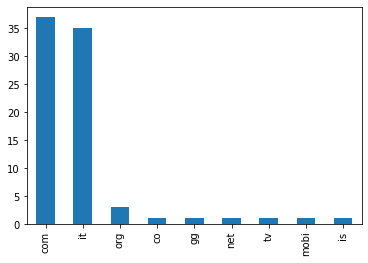

In [5]:
# TLDs

urls = report_json["url"]
ul = urls.tolist()

tlds = {}
for url in ul:
    tld = ((url.split(".")[len(url.split(".")) - 1]).split("/")[0]).split(":")[0]
    if tld in tlds.keys():
        tlds[tld] = tlds[tld] + 1
    else:
        tlds[tld] = 1
        
pd.Series(tlds).sort_values(ascending = False).plot.bar()
plt.show()

## 2 Simple analysis

In [10]:
# Open policy files
policy_file_names = successful["policy_file"].tolist()

### 2.1 Language detection

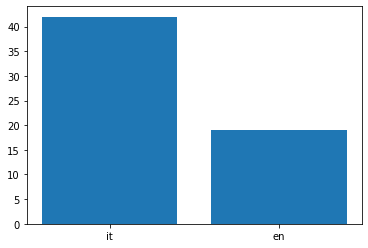

In [35]:
# Language detection
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))


languages = {}
for file in policy_files:
    languages[file.name] = langid.classify(file.read())[0]

plt.bar(pd.Series(languages).value_counts().keys(), pd.Series(languages).value_counts())
plt.show()

### 2.2 Wordcounts

it
42 total policies


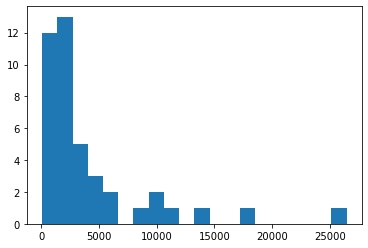

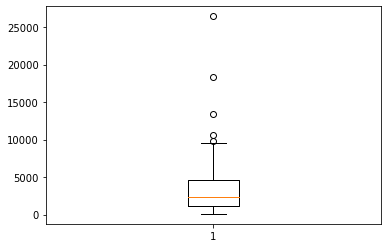

en
19 total policies


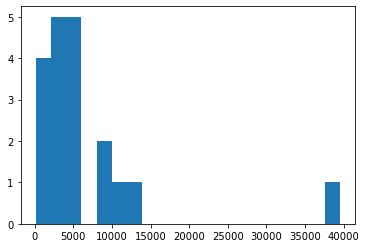

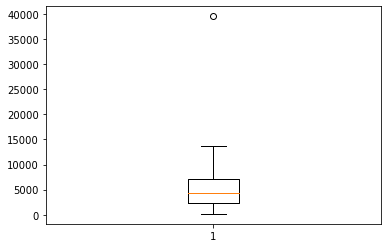

In [48]:
# Simple analysis i.e. wordcount
# Include language in wordcount?

# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))
    

for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)
    print(str(len(policy_files)) + " total policies")
    
    wordcounts = []
    for file in policy_files:
        wordcounts.append(len(file.read().split()))

    plt.hist(wordcounts, 20)
    plt.show()
    plt.boxplot(wordcounts)
    plt.show()


# wordcounts = []
# for file in policy_files:
#     wordcounts.append(len(file.read().split()))

# plt.hist(wordcounts, 20)
# plt.show()
# plt.boxplot(wordcounts)
# plt.show()

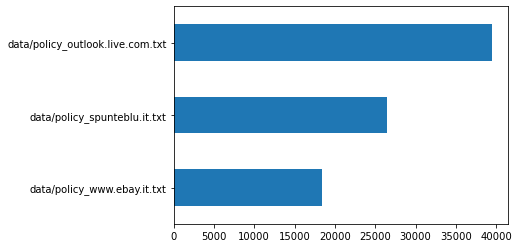

In [7]:
# Top 3 longest policies by wordcount

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

wc_dict = {}

for file in policy_files:
    wc_dict[file.name] = len(file.read().split())
    
wc_s = pd.Series(wc_dict).sort_values(ascending=True)
wc_s[len(wc_s) - 3:].plot.barh()
plt.show()

In [8]:
wc_s[len(wc_s) - 3:]

data/policy_www.ebay.it.txt         18406
data/policy_spunteblu.it.txt        26444
data/policy_outlook.live.com.txt    39529
dtype: int64

### 2.3 Wordclouds

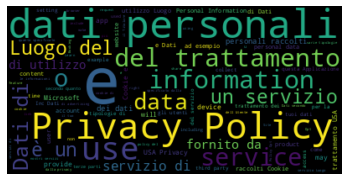

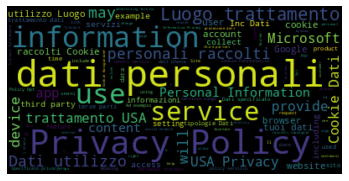

In [23]:
# Some fun wordclouds :)
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text = ""
for file in policy_files:
    all_policy_text += file.read()

wordcloud = WordCloud().generate(all_policy_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Unsurprisingly you have to filter out heaps of words...
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text_filtered = ""
for file in policy_files:
    for word in file.read().split():
        if word not in (justext.get_stoplist("Italian")):
            all_policy_text_filtered += word + " "

wordcloud = WordCloud().generate(all_policy_text_filtered)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.4 Emotion analysis

In [11]:
# Text2Emotion
import text2emotion as t2e
import emoji
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

In [18]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

In [19]:
for file in policy_files:
    emotions = t2e.get_emotion(file.read())
    top_emotion = max(emotions)
    emotions_dict[top_emotion] = emotions_dict[top_emotion] + 1

emotions_dict

{'Angry': 0, 'Fear': 0, 'Happy': 0, 'Sad': 0, 'Surprise': 65}

In [21]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

for file in policy_files:
    emotions = t2e.get_emotion(file.read())
    for emotion in emotions:
        emotions_dict[emotion] = emotions_dict[emotion] + emotions[emotion] # maybe normalize?

emotions_dict

{'Angry': 1.7400000000000007,
 'Fear': 40.48000000000001,
 'Happy': 7.440000000000001,
 'Sad': 10.629999999999995,
 'Surprise': 4.679999999999999}

In [22]:
for e in emotions_dict.keys():
    emotions_dict[e] = round(emotions_dict[e] / len(policy_files), 3)

emotions_dict

{'Angry': 0.027,
 'Fear': 0.623,
 'Happy': 0.114,
 'Sad': 0.164,
 'Surprise': 0.072}